<h1 style='color:orange; font-weight:bold; text-align:center'>Latent Semantic Analysis with Truncated Singular Value Decomposition</h1>

In [14]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import CoherenceModel
import gensim.corpora as corpora

In [15]:
# load the dataset
df4 = pd.read_csv('../data/review_gopay_newest_sort.csv')

In [16]:
# prepare stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh', 'ya', 'kan', 'nih', 'nya'}
stop_words.update(custom_stopwords)

In [17]:
# find which words are in the stop_words set
negations = {'tidak', 'ga', 'gk', 'tdk'}
words_in_stopwords = negations.intersection(stop_words)
words_not_in_stopwords = negations.difference(stop_words)

# print the result
print("Words in stop_words:", words_in_stopwords)
print("Words not in stop_words:", words_not_in_stopwords)

Words in stop_words: {'tidak'}
Words not in stop_words: {'ga', 'tdk', 'gk'}


In [18]:
# define synonym dictionary
synonym_dict = {
    'apk': 'aplikasi', 'app': 'aplikasi', 
    'oke': 'ok', 'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak',
    'g':'tidak', 'tf': 'transfer', 'yg': 'yang', 'bgt': 'banget'
}

# function to normalize elongated words (e.g., sukaaaa -> suka)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1', word)                            # replace >=3 chars with 1 char

In [19]:
# preprocess function
def preprocess_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', ' ', text)                                # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        tokens = text.split()                                           # split into tokens
        tokens = [normalize_repeated_chars(word) for word in tokens]    # normalize elongated words
        tokens = [synonym_dict.get(word, word) for word in tokens]      # replace with synonym if it exists
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return ' '.join(tokens)                                         # return cleaned text as a single string
    return ''                                                           # return empty str for non-string values

# apply preprocessing
df4['cleaned_content'] = df4['content'].apply(preprocess_text)

In [21]:
# check preprocessing output
df4.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,cleaned_content
0,Pengguna Google,Mantap,5,0,1.24.1,2024-07-07 16:58:06,mantap
1,Pengguna Google,Bagus dan mudah digunakan,5,0,1.24.1,2024-07-07 16:57:08,bagus mudah
2,Pengguna Google,Good,5,0,1.24.1,2024-07-07 16:52:38,good
3,Pengguna Google,Sangat membantu orang menengah mantap semoga s...,5,0,1.24.1,2024-07-07 16:52:36,membantu orang menengah mantap semoga sukses g...
4,Pengguna Google,Ga ribet .. Sukaaaa,5,0,1.24.1,2024-07-07 16:52:09,ribet suka


In [22]:
# vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # limit to 5000 words
tfidf_matrix = vectorizer.fit_transform(df4['cleaned_content'])

# convert to Gensim corpus for coherence score
texts = [text.split() for text in df4['cleaned_content']]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
# grid search for optimal number of topics
topics_range = range(2, 11) 
coherence_scores = []
reconstruction_errors = []

for num_topics in topics_range:
    # create and train the LSA model using Truncated SVD
    print(f'Training model with {num_topics} topics...')
    svd_model = TruncatedSVD(n_components=num_topics, random_state=42)
    svd_model.fit(tfidf_matrix)
    
    # get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    topic_words = [[feature_names[i] for i in topic.argsort()[-10:]] for topic in svd_model.components_]
    
    # compute coherence score using Gensim's CoherenceModel
    coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    # compute reconstruction error
    reconstructed_matrix = svd_model.inverse_transform(svd_model.transform(tfidf_matrix))
    reconstruction_error = mean_squared_error(tfidf_matrix.toarray(), reconstructed_matrix)
    reconstruction_errors.append(reconstruction_error)
    
    print(f'Num topics: {num_topics}, coherence score: {coherence_score:.4f}, reconstruction error: {reconstruction_error:.4f}')

Training model with 2 topics...
Num topics: 2, coherence score: 0.3986, reconstruction error: 0.0002
Training model with 3 topics...
Num topics: 3, coherence score: 0.3666, reconstruction error: 0.0002
Training model with 4 topics...
Num topics: 4, coherence score: 0.3943, reconstruction error: 0.0001
Training model with 5 topics...
Num topics: 5, coherence score: 0.3843, reconstruction error: 0.0001
Training model with 6 topics...
Num topics: 6, coherence score: 0.4165, reconstruction error: 0.0001
Training model with 7 topics...


Python(5212) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Num topics: 7, coherence score: 0.4258, reconstruction error: 0.0001
Training model with 8 topics...


Python(5244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Num topics: 8, coherence score: 0.4305, reconstruction error: 0.0001
Training model with 9 topics...


Python(5283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5293) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Num topics: 9, coherence score: 0.4527, reconstruction error: 0.0001
Training model with 10 topics...


Python(5347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(5359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Num topics: 10, coherence score: 0.4648, reconstruction error: 0.0001


In [24]:
# choose the optimal number of topics
optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print(f'Optimal Number of Topics: {optimal_num_topics}')

Optimal Number of Topics: 10


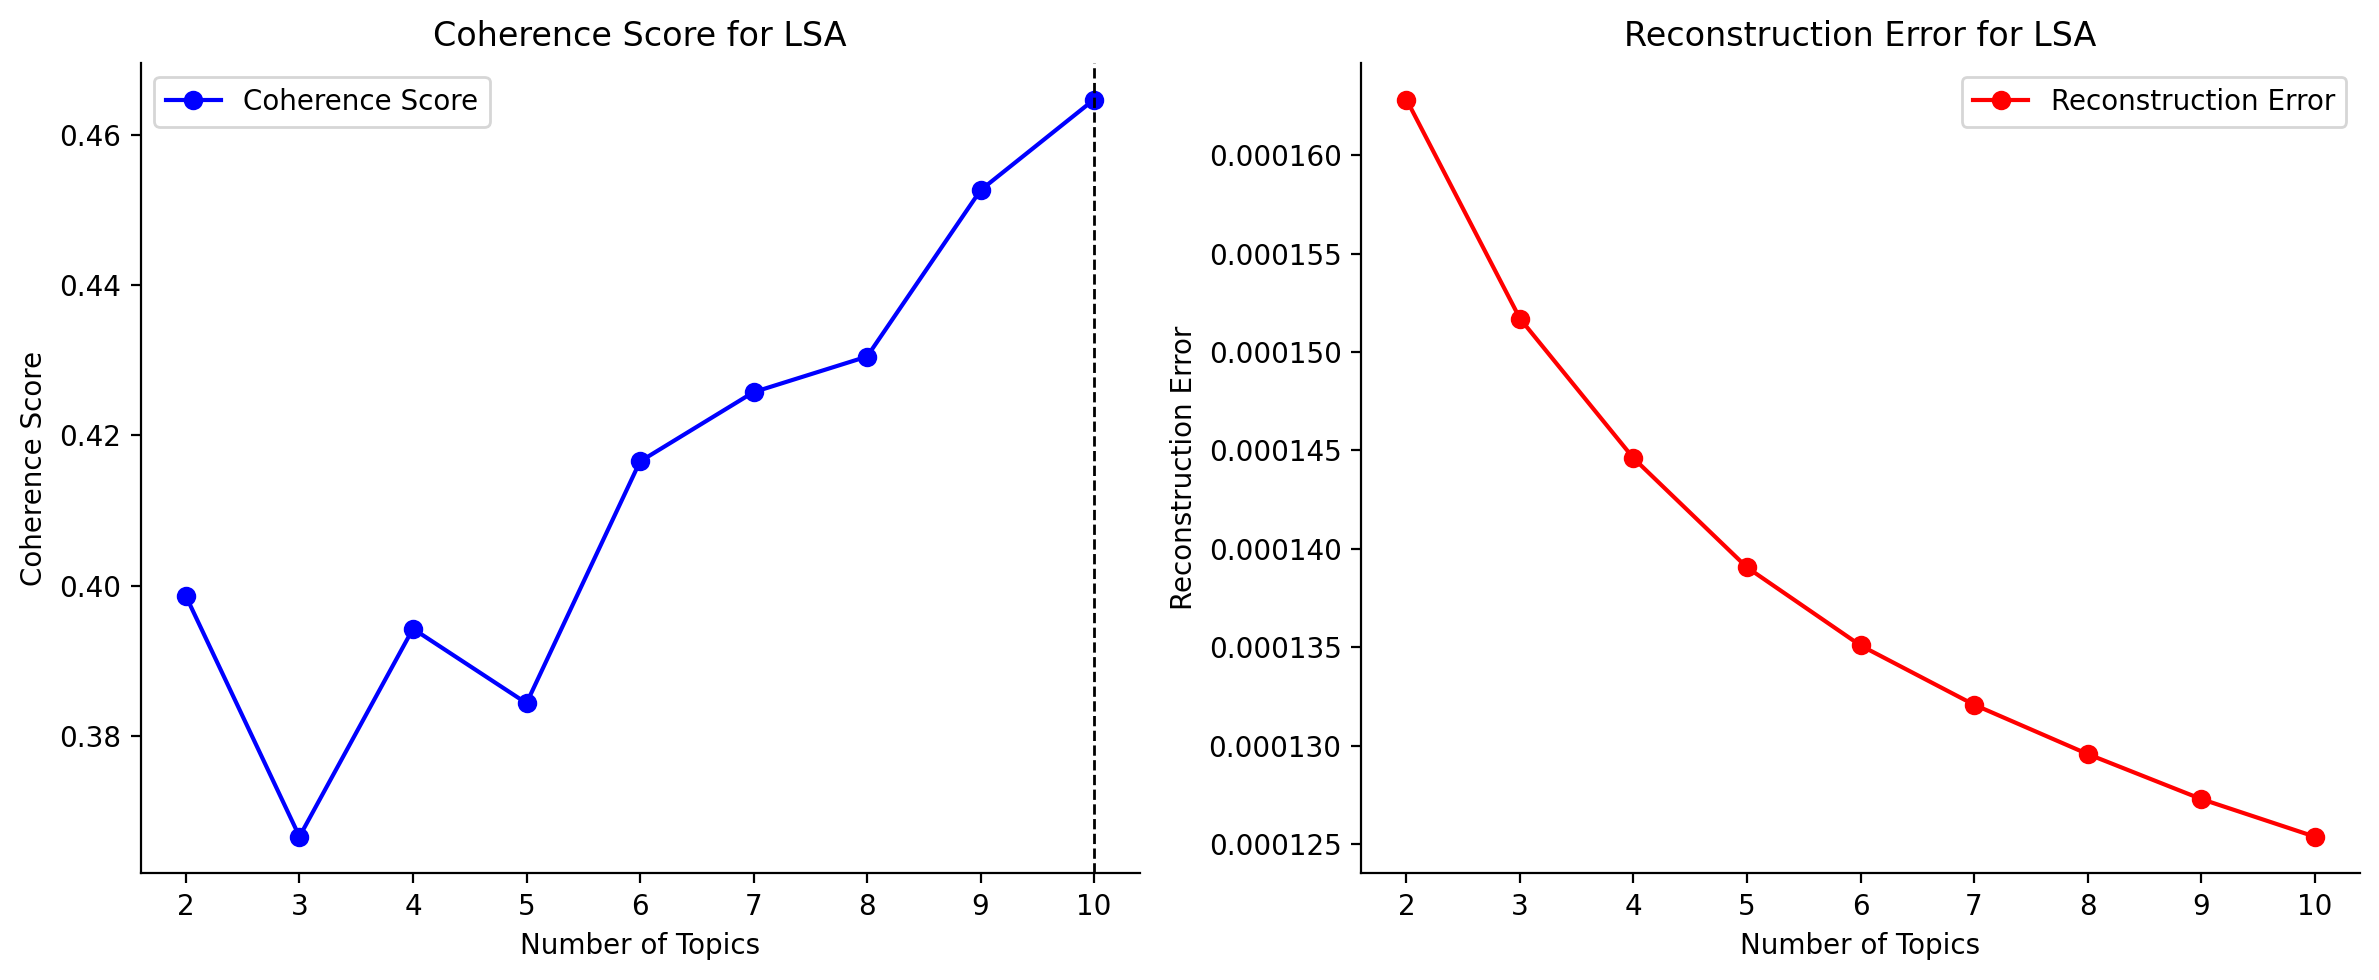

In [25]:
# plot for ooherence score
plt.figure(figsize=(12, 5), dpi=200)

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(topics_range, coherence_scores, marker='o', label='Coherence Score', color='blue')
plt.axvline(x=optimal_num_topics, linestyle='--', color='black', linewidth=1)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score for LSA')
plt.xticks(topics_range)
# plt.grid()
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# plot for reconstruction error
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(topics_range, reconstruction_errors, marker='o', label='Reconstruction Error', color='red')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error for LSA')
plt.xticks(topics_range)
# plt.grid(None)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()  
plt.show()

In [26]:
# train LSA model w/ optimal number of topics
svd_model = TruncatedSVD(n_components=optimal_num_topics, random_state=42)
svd_model.fit(tfidf_matrix)

TruncatedSVD(n_components=10, random_state=42)

In [27]:
# print topics
for topic_idx, topic in enumerate(svd_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # top 10 words for topic
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: transaksi, banget, cepat, mudah, membantu, aplikasi, gopay, ok, bagus, mantap
Topic 1: transaksi, cepat, gopay, aplikasinya, mudah, banget, membantu, ok, aplikasi, bagus
Topic 2: transaksi, cepat, mudah, good, sip, bgt, membantu, gopay, banget, ok
Topic 3: terimakasih, banget, transfer, cepat, good, transaksi, gopay, mudah, aplikasi, membantu
Topic 4: keren, transaksi, banget, cepat, very, mudah, gopay, job, aplikasi, good
Topic 5: praktis, banget, aman, keren, transfer, transaksi, cepat, gopay, aplikasi, mudah
Topic 6: pakai, pake, terbaik, transfer, top, suka, banget, keren, gopay, aplikasi
Topic 7: pokoknya, abis, mudah, bagus, membantu, good, cepat, aplikasinya, banget, keren
Topic 8: saldo, kasih, terimakasih, pake, pakai, top, transaksi, banget, transfer, gopay
Topic 9: praktis, bank, prosesnya, gratis, banget, aman, proses, transfer, transaksi, cepat


In [19]:
# Assign topics to documents
document_topics = svd_model.transform(tfidf_matrix)
df4['topic'] = document_topics.argmax(axis=1)  # Assign the topic with the highest score